In [25]:
# import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [32]:
# Load LIWC features
train_liwc = pd.read_pickle("../data/task1_LIWC_train.pickle")
val_liwc = pd.read_pickle("../data/task1_LIWC_val.pickle")

# Load targets
train_df = pd.read_pickle("../data/train.pickle")
val_df = pd.read_pickle("../data/val.pickle")

print(f"LIWC train shape: {train_liwc.shape}")
print(f"LIWC val shape: {val_liwc.shape}")
print(f"Target train shape: {train_df.shape}")
print(f"Target val shape: {val_df.shape}")
print(f"\nLIWC columns: {list(train_liwc.columns)[:10]}... ({len(train_liwc.columns)} total)")


LIWC train shape: (2211, 90)
LIWC val shape: (553, 90)
Target train shape: (2211, 8)
Target val shape: (553, 8)

LIWC columns: ['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'text_tokens', 'text_liwc_tokens']... (90 total)


In [42]:
# Data preparation and filtering
print("=" * 60)
print("DATA PREPARATION")
print("=" * 60)

# Reset indices to ensure alignment
train_liwc = train_liwc.reset_index(drop=True)
val_liwc = val_liwc.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Extract true LIWC features (exclude metadata and target columns)
# These are the real LIWC categories, excluding: user_id, text_id, valence, arousal, collection_phase, is_words, num_tokens
exclude_cols = ['user_id', 'text_id', 'valence', 'arousal', 'collection_phase', 'is_words', 'num_tokens']
liwc_feature_cols = [col for col in train_liwc.columns if col not in exclude_cols and col not in ['text', 'timestamp', 'text_tokens', 'text_liwc_tokens']]

print(f"Real LIWC feature columns ({len(liwc_feature_cols)}): {liwc_feature_cols[:10]}...")

X_train_liwc = train_liwc[liwc_feature_cols].values.astype(float)
X_val_liwc = val_liwc[liwc_feature_cols].values.astype(float)

# Extract targets and user_ids
y_train = train_df[['valence', 'arousal']].values.astype(float)
y_val = val_df[['valence', 'arousal']].values.astype(float)
train_user_ids = train_df['user_id'].values
val_user_ids = val_df['user_id'].values

# Filter out NaN targets
valid_train_idx = ~(np.isnan(y_train).any(axis=1))
valid_val_idx = ~(np.isnan(y_val).any(axis=1))

X_train_liwc = X_train_liwc[valid_train_idx]
X_val_liwc = X_val_liwc[valid_val_idx]
y_train = y_train[valid_train_idx]
y_val = y_val[valid_val_idx]
train_user_ids = train_user_ids[valid_train_idx]
val_user_ids = val_user_ids[valid_val_idx]
# Standardize LIWC features
scaler = StandardScaler()
X_train_liwc = scaler.fit_transform(X_train_liwc)
X_val_liwc = scaler.transform(X_val_liwc)
print(f"After filtering NaN:")
print(f"  X_train_liwc: {X_train_liwc.shape}")
print(f"  X_val_liwc: {X_val_liwc.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  LIWC feature dimension: {X_train_liwc.shape[1]}")
print(f"  NaN in X_train: {np.isnan(X_train_liwc).sum()}")
print(f"  NaN in y_train: {np.isnan(y_train).sum()}")
print(f"  NaN in X_val: {np.isnan(X_val_liwc).sum()}")
print(f"  NaN in y_val: {np.isnan(y_val).sum()}")
print("=" * 60)


DATA PREPARATION
Real LIWC feature columns (79): ['ACHIEV', 'ADJ', 'ADVERB', 'AFFECT', 'AFFILIATION', 'ANGER', 'ANX', 'ARTICLE', 'ASSENT', 'AUXVERB']...
After filtering NaN:
  X_train_liwc: (2211, 79)
  X_val_liwc: (553, 79)
  y_train: (2211, 2)
  y_val: (553, 2)
  LIWC feature dimension: 79
  NaN in X_train: 0
  NaN in y_train: 0
  NaN in X_val: 0
  NaN in y_val: 0


In [44]:
# MLP Model - same structure as item_score_baseline

class MLPModel(nn.Module):
    def __init__(self, liwc_dim=85, num_users=1000, user_embedding_dim=32, hidden_dim=256):
        super(MLPModel, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = LIWC features + user embedding
        input_dim = liwc_dim + user_embedding_dim
        
        # Simple MLP layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Predict valence and arousal
        
    def forward(self, x_liwc, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)  # (batch_size, user_embedding_dim)
        
        # Concatenate LIWC features and user embedding
        combined = torch.cat([x_liwc, user_embed], dim=1)  # (batch_size, liwc_dim + user_embedding_dim)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_liwc, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_liwc, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Map user IDs to 0-indexed
user_id_map = {}
train_user_id_list = []
for uid in train_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    train_user_id_list.append(user_id_map[uid])

val_user_id_list = []
for uid in val_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    val_user_id_list.append(user_id_map[uid])

train_user_ids_tensor = torch.tensor(train_user_id_list, dtype=torch.long).to(device)
val_user_ids_tensor = torch.tensor(val_user_id_list, dtype=torch.long).to(device)

num_unique_users = len(user_id_map)
print(f"Number of unique users: {num_unique_users}")
print(f"Input dimension: LIWC ({X_train_liwc.shape[1]}) + User embedding (32) = {X_train_liwc.shape[1] + 32}")


Using device: cuda
Number of unique users: 137
Input dimension: LIWC (79) + User embedding (32) = 111


In [45]:
# Train MLP model with early stopping
import torch.nn as nn
import torch.optim as optim

model = MLPModel(liwc_dim=X_train_liwc.shape[1], num_users=num_unique_users, user_embedding_dim=32, hidden_dim=256)
model = model.to(device)

# Initialize weights
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with early stopping
num_epochs = 100
batch_size = 32
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement to wait before stopping
patience_counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    num_batches = 0
    
    for i in range(0, len(X_train_tensor), batch_size):
        batch_x = X_train_tensor[i:i+batch_size]
        batch_user_ids = train_user_ids_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(batch_x, batch_user_ids)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    train_loss /= num_batches
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor, val_user_ids_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0 or (epoch + 1) == 1:
        print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss.item():.6f}, Patience = {patience_counter}/{patience}")
    
    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Stop training if patience exceeded
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

print(f"Training completed! Total epochs: {epoch+1}/{num_epochs}")
print("-" * 60)


Starting training...
------------------------------------------------------------
Epoch   1: Train Loss = 1.232274, Val Loss = 1.092970, Patience = 0/10
Epoch  10: Train Loss = 0.674698, Val Loss = 0.694983, Patience = 0/10
Epoch  20: Train Loss = 0.567484, Val Loss = 0.629168, Patience = 0/10
Epoch  30: Train Loss = 0.488747, Val Loss = 0.611737, Patience = 1/10
Epoch  40: Train Loss = 0.444596, Val Loss = 0.618309, Patience = 8/10

Early stopping at epoch 41
Best validation loss: 0.608279
Training completed! Total epochs: 41/100
------------------------------------------------------------


In [46]:
# Evaluate performance
print("=" * 60)
print("LIWC BASELINE MODEL (LIWC + USER_ID) PERFORMANCE")
print("=" * 60)

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor, train_user_ids_tensor)
    val_predictions = model(X_val_tensor, val_user_ids_tensor)

# Convert to numpy
train_preds_np = train_predictions.cpu().numpy()
val_preds_np = val_predictions.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_mse = mean_squared_error(y_train_np, train_preds_np)
train_mae = mean_absolute_error(y_train_np, train_preds_np)
val_mse = mean_squared_error(y_val_np, val_preds_np)
val_mae = mean_absolute_error(y_val_np, val_preds_np)

print(f"Train - MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
print(f"Val   - MSE: {val_mse:.6f}, MAE: {val_mae:.6f}")

# Per-dimension metrics
train_mse_valence = mean_squared_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mse_arousal = mean_squared_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mse_valence = mean_squared_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mse_arousal = mean_squared_error(y_val_np[:, 1], val_preds_np[:, 1])

train_mae_valence = mean_absolute_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mae_arousal = mean_absolute_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mae_valence = mean_absolute_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mae_arousal = mean_absolute_error(y_val_np[:, 1], val_preds_np[:, 1])

print(f"\nValence - Train MSE: {train_mse_valence:.6f}, Val MSE: {val_mse_valence:.6f}")
print(f"Arousal  - Train MSE: {train_mse_arousal:.6f}, Val MSE: {val_mse_arousal:.6f}")
print(f"\nValence - Train MAE: {train_mae_valence:.6f}, Val MAE: {val_mae_valence:.6f}")
print(f"Arousal  - Train MAE: {train_mae_arousal:.6f}, Val MAE: {val_mae_arousal:.6f}")
print("=" * 60)


LIWC BASELINE MODEL (LIWC + USER_ID) PERFORMANCE
Train - MSE: 0.395125, MAE: 0.487524
Val   - MSE: 0.619565, MAE: 0.599745

Valence - Train MSE: 0.500625, Val MSE: 0.831603
Arousal  - Train MSE: 0.289624, Val MSE: 0.407526

Valence - Train MAE: 0.552294, Val MAE: 0.699679
Arousal  - Train MAE: 0.422752, Val MAE: 0.499812


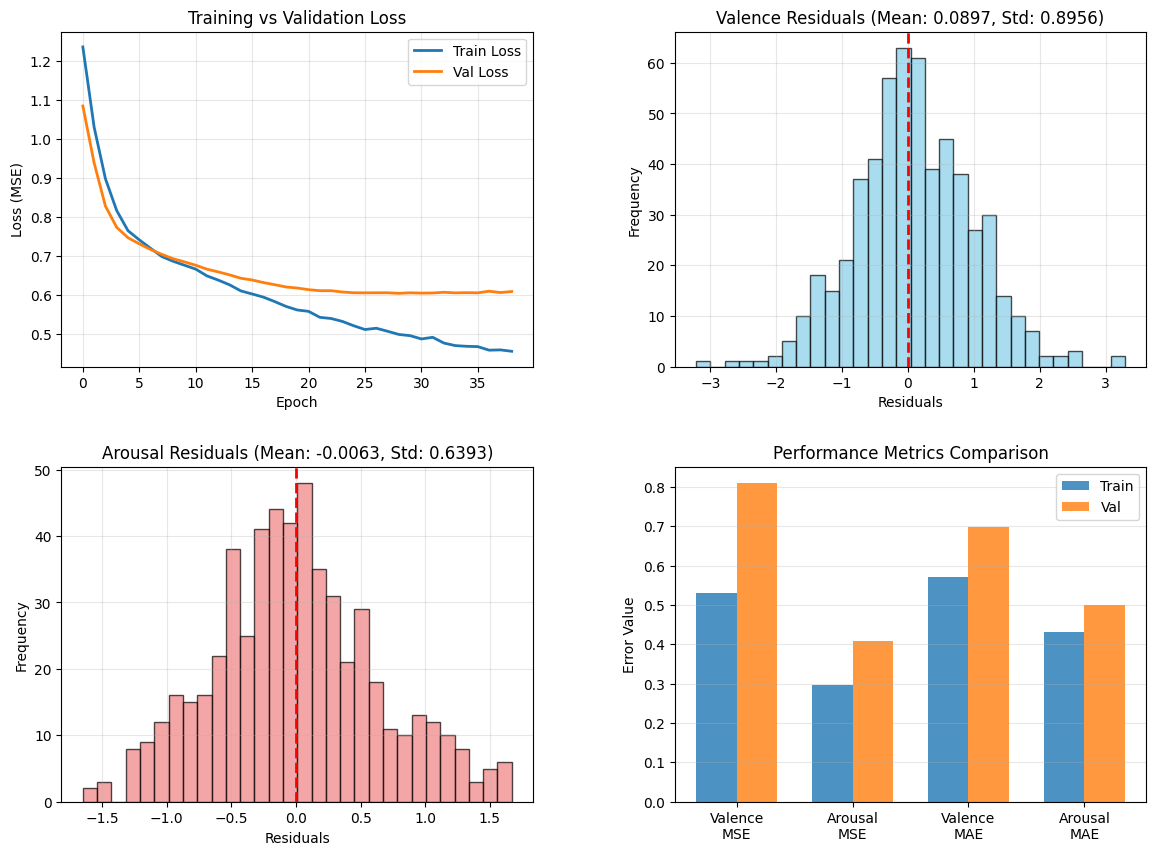

Visualization saved as 'liwc_baseline_attention_performance.png'


In [41]:
# Visualization - LIWC Baseline Performance (Simplified)
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Training vs Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4. Valence residuals distribution
ax4 = fig.add_subplot(gs[0, 1])
valence_residuals = y_val_np[:, 0] - val_preds_np[:, 0]
ax4.hist(valence_residuals, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Valence Residuals (Mean: {valence_residuals.mean():.4f}, Std: {valence_residuals.std():.4f})')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3)

# 5. Arousal residuals distribution
ax5 = fig.add_subplot(gs[1, 0])
arousal_residuals = y_val_np[:, 1] - val_preds_np[:, 1]
ax5.hist(arousal_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Arousal Residuals (Mean: {arousal_residuals.mean():.4f}, Std: {arousal_residuals.std():.4f})')
ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax5.grid(True, alpha=0.3)

# 9. Performance metrics comparison
ax9 = fig.add_subplot(gs[1, 1])
metrics_names = ['Valence\nMSE', 'Arousal\nMSE', 'Valence\nMAE', 'Arousal\nMAE']
train_metrics = [train_mse_valence, train_mse_arousal, train_mae_valence, train_mae_arousal]
val_metrics = [val_mse_valence, val_mse_arousal, val_mae_valence, val_mae_arousal]

x = np.arange(len(metrics_names))
width = 0.35
ax9.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
ax9.bar(x + width/2, val_metrics, width, label='Val', alpha=0.8)
ax9.set_ylabel('Error Value')
ax9.set_title('Performance Metrics Comparison')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_names)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.savefig('liwc_baseline_attention_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'liwc_baseline_attention_performance.png'")
